In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
import pandas as pd

import rubin_sim.maf as maf
from rubin_sim.scheduler.utils import EuclidOverlapFootprint
from rubin_sim.data import get_baseline
from rubin_sim.phot_utils import DustValues


In [2]:
# Let's update to include dust extinction


class AccumulateM5Metric(maf.metrics.AccumulateMetric):
    def __init__(
        self, bins=None, bin_col="night", m5_col="fiveSigmaDepth", metric_name="AccumulateM5Metric", filter_col="filter",
        dust=False,
        **kwargs
    ):
        self.m5_col = m5_col
        self.filter_col = filter_col
        maps = ["DustMap"]
        super(AccumulateM5Metric, self).__init__(
            bins=bins, bin_col=bin_col, col=[m5_col, filter_col],
            metric_name=metric_name, maps=maps,**kwargs
        )
        dust_properties = DustValues()
        self.ax1 = dust_properties.ax1
        self.dust=dust

    def run(self, data_slice, slice_point=None):
        data_slice.sort(order=self.bin_col)
        flux = 10.0 ** (0.8 * data_slice[self.m5_col])

        result = np.add.accumulate(flux)
        indices = np.searchsorted(data_slice[self.bin_col], self.bins[1:], side="right")
        indices[np.where(indices >= np.size(result))] = np.size(result) - 1
        result = result[indices]
        result = 1.25 * np.log10(result)

        if self.dust:
            a_x = self.ax1[data_slice[self.filter_col][0]] * slice_point["ebv"]
            result -= a_x
        
        result[np.where(indices == 0)] = self.badval
        return result


In [3]:
baseline_file = get_baseline()
name = os.path.basename(baseline_file).replace('.db','')
out_dir = 'temp'
results_db = maf.db.ResultsDb(out_dir=out_dir)


In [4]:
bundle_list = []
nside =128

fpg = EuclidOverlapFootprint(nside=nside)
fp, labels = fpg.return_maps()

in_exgal = np.where((labels == "lowdust"))[0]


bins=np.arange(0,365.25*10, 10)
# col here could be anything
metric = AccumulateM5Metric(bins=bins, dust=True)
# Select all the visits. Could do something like 'filter="r"' 
sql = 'filter="r"'
slicer = maf.slicers.HealpixSlicer(nside=nside,use_cache=False)
plot_dict = {}
bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=name, plot_dict=plot_dict))

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


In [5]:
bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, baseline_file, out_dir=out_dir, results_db=results_db)
bg.run_all()
#bg.plot_all(closefigs=False)

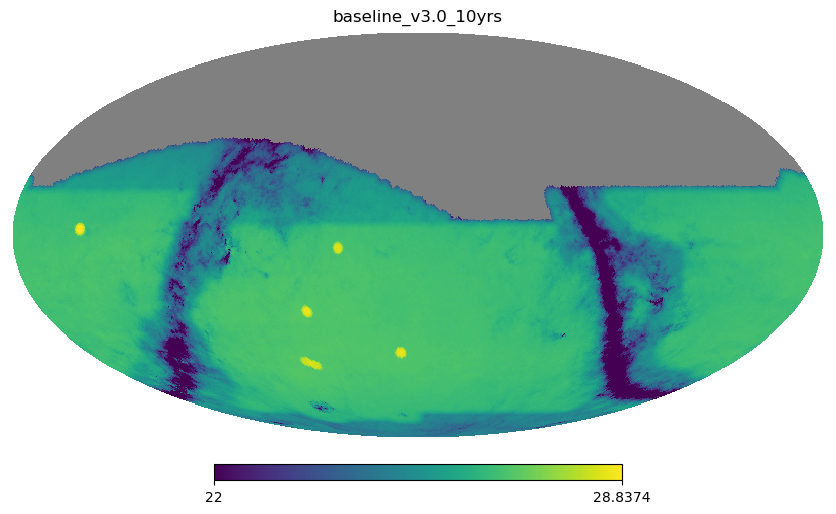

In [6]:
hp.mollview(bundle_list[0].metric_values[:,-1], title=name, min=22)

In [7]:
bundle_list[0].metric_values.shape

(196608, 365)

In [8]:
# ok, for each time step we want to know the peak depth, and then the number of pixels around some range of that peak

mag_peaks = []
n_pix = []
bins = np.arange(18,32, 0.025)
x = (bins[0:-1] + bins[:-1])/2.
around = np.array([-1,0,1])
pad = 0.15 # mags

ld = np.where(labels == "lowdust")[0]

for i in np.arange(bundle_list[0].metric_values.shape[-1]):
    slice = bundle_list[0].metric_values[:,i]
    ack, _b = np.histogram(slice[ld], bins=bins)
    peak = np.min(np.where(ack == np.max(ack))[0])
    mag_val = np.average(x[around + peak], weights=ack[around + peak])
    mag_peaks.append(mag_val)
    n_pix_near = np.size(np.where((slice > (mag_val-pad)) & 
                                  (slice < (mag_val+pad)) &
                                   (labels == "lowdust"))[0])
    n_pix.append(n_pix_near)

areas = np.array(n_pix) * hp.nside2pixarea(nside, degrees=True)

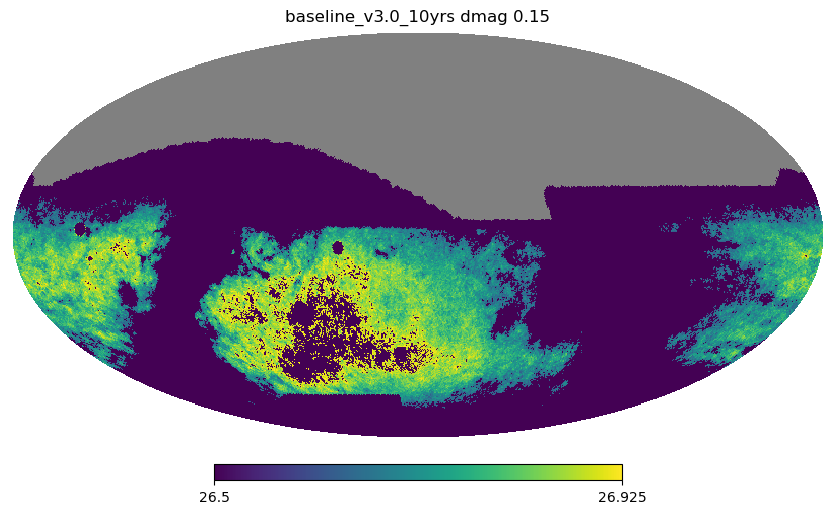

In [9]:

indx = np.where((slice > (mag_val-pad)) & 
                                  (slice < (mag_val+pad)) &
                                   (labels == "lowdust"))[0]
mask = slice*0
mask[indx] = 1
masked = slice * mask
hp.mollview(masked, min=26.5, title=name+' dmag %.2f' %pad)

Text(0.5, 1.0, 'baseline_v3.0_10yrs')

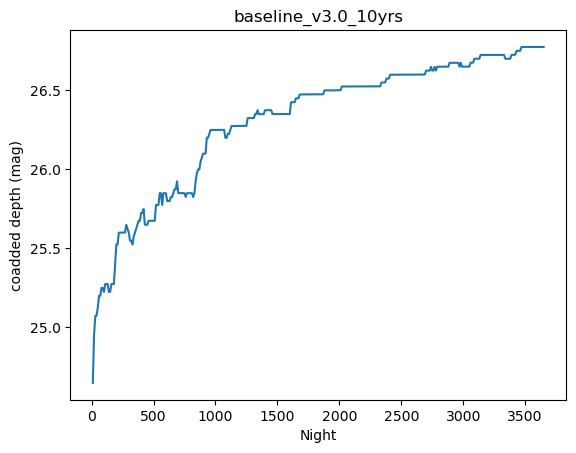

In [13]:
bins = np.arange(0,365.25*10, 10)
plt.plot(bins[1:], mag_peaks)
plt.xlabel('Night')
plt.ylabel('coadded depth (mag)')
plt.title(name)

Text(0.5, 1.0, 'baseline_v3.0_10yrs')

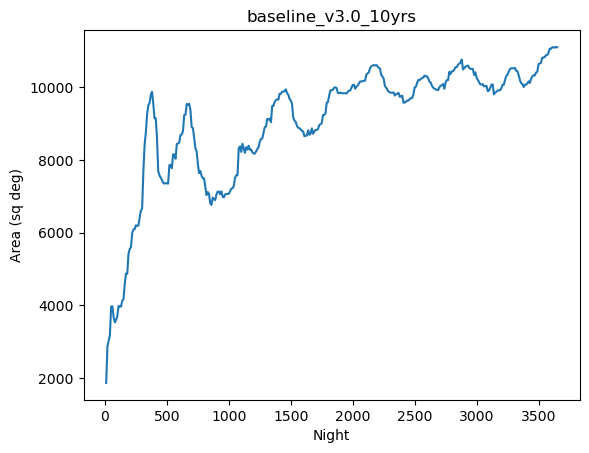

In [15]:
plt.plot(bins[1:], areas)
plt.xlabel('Night')
plt.ylabel('Area (sq deg)')
plt.title(name)

In [12]:
years = np.arange(365.25, 365.25*11, 365.25)

mag_int = np.interp(years, bins[1:], mag_peaks)
area_int = np.interp(years, bins[1:], areas)

df = pd.DataFrame()
df['year'] = np.round(years/365.25)
df['mag'] = mag_int
df['Area'] = area_int

df

,year,mag,Area
0,1.0,25.638286,9683.004223
1,2.0,25.850071,8321.606983
2,3.0,26.214286,8286.818262
3,4.0,26.350286,9933.501903
4,5.0,26.475331,9915.808543
5,6.0,26.525456,10605.954462
6,7.0,26.599948,10246.474503
7,8.0,26.674642,10581.940173
8,9.0,26.724607,10525.744218
9,10.0,26.775005,11100.917398
